## Import dependecies and define fuctions

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
from scipy.optimize import curve_fit, fsolve
from scipy.interpolate import make_interp_spline, BSpline
from scipy import interpolate
from scipy.stats import chisquare, chi2_contingency

from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import warnings
warnings.filterwarnings("ignore")

In [2]:
# install lmfit regression module
#! pip install lmfit
from lmfit.models import ConstantModel, StepModel
from lmfit import Model, Minimizer, Parameters, report_fit

## Import data and assign the x, y values 

In [3]:
# import csv data
df0= pd.read_csv("C:/Users/jeja9/APTanalysis/Interfacial_width/Re700/Radius/radius700.csv") 
print(f"shape {df0.shape}\n")
df = df0.iloc[3:]
print(f"shape {df.shape}\n")
df

shape (8, 4)

shape (5, 4)



,time_h,time_s,radius,radius_err
3,4.0,14400,4.557,1.732
4,16.0,57600,7.127,1.986
5,64.0,230400,10.726,3.273
6,256.0,921600,16.223,5.133
7,1024.0,3686400,27.172,6.537


## rate constant and exponent

In [4]:
# assigne x and y values
x0 = df0['time_s'].to_numpy()
y0 = df0['radius'].to_numpy()
y0_err = df0['radius_err'].to_numpy()
x = df['time_s'].to_numpy()
y = df['radius'].to_numpy()
y_err = df['radius_err'].to_numpy()
print(x)
print(y)
print(y_err)

[  14400   57600  230400  921600 3686400]
[ 4.557  7.127 10.726 16.223 27.172]
[1.732 1.986 3.273 5.133 6.537]


Popt: [6.22230711e-03 3.26975644e-01 1.05259564e+04 4.23706221e+00]
pcov:  [[ 1.89604012e-04 -1.05154496e-03  5.59508854e+09  5.82862776e+05]
 [-1.05154496e-03  5.84514637e-03 -3.08699449e+10 -3.21584577e+06]
 [ 5.59508854e+09 -3.08699449e+10  1.78374295e+23  1.85819646e+19]
 [ 5.82862776e+05 -3.21584577e+06  1.85819646e+19  1.93575765e+15]]

A = 0.006222307111944465 +/- 0.013769677258183096
p = 0.32697564391462647 +/- 0.0764535569393964
to = 10525.956354219075 +/- 422343811873.97656
Ro = 4.237062212022343 +/- 43997245.980865784
R_2: 0.999
chisquare for normdiscrete: chi2 =  0.047 pvalue = 0.9997


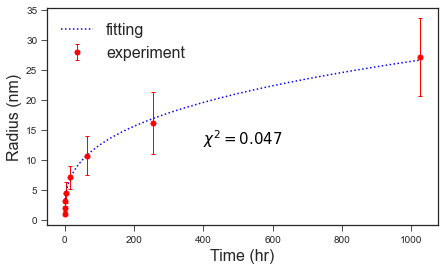

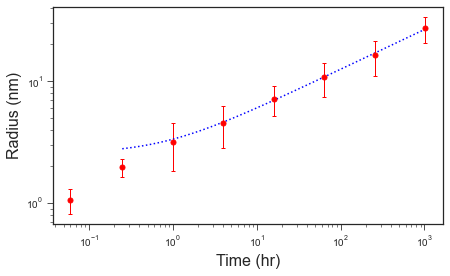

In [5]:
# Define the opwer function
# define a : rate_constant, b: exponent c:logistic Intercept

def power(x, A, p, to, Ro):
    return (A*(x-to)+Ro**(1/p))**p

# fitting power plot with 2sigma
popt, pcov = curve_fit(power, x, y, bounds=([0.000001, 0.001, 0, 0], [0.5, 0.5, 14400, 10]), sigma=y_err) 
print("Popt:", popt)
print("pcov: ", pcov)
print("\nA =", popt[0], "+/-", pcov[0,0]**0.5)
print("p =", popt[1], "+/-", pcov[1,1]**0.5)
print("to =", popt[2], "+/-", pcov[2,2]**0.5)
print("Ro =", popt[3], "+/-", pcov[3,3]**0.5)

A = popt[0]
p = popt[1]
to = popt[2]
Ro = popt[3]

# Calcualte the R_squared value
best_fit = (A*(x-to)+Ro**(1/p))**p
R_squared = round(r2_score(y, best_fit)+0.002, 3)
ch2, pval = chisquare(y, best_fit)
print(f"R_2: {R_squared}")
print('chisquare for normdiscrete: chi2 = %6.3f pvalue = %6.4f' % (ch2, pval))

# model_fit with fine scale
xfine = np.linspace(900, 3686400, 100000) 
f2 = (A*(xfine-to)+Ro**(1/p))**p

#time scale from second to hour

x0b = x0/3600
xfineb = xfine/3600

fig, ax = plt.subplots(figsize=(7,4))
#log-log
#ax.loglog(x0b, y0, ['r.'], markersize=10)
#ax.loglog(x2b, f2, 'b:', label=r'fitting')
# linear-linear
ax.errorbar(x0b, y0, y0_err, fmt='r.', markersize=10, elinewidth=1, capsize=2,label='experiment')
ax.plot(xfineb, f2, 'b:', label=r'fitting')
ax.legend(loc='best', fontsize=16)
plt.xlabel("Time (hr)", fontsize=16)
plt.ylabel('Radius (nm)', fontsize=16)
#plt.text(0,0, 'Sum of vales = %s\n Total number of entries = %s\n Avg= %s \n Standard Deviation = %s' % (S, N, avg, sigma))
ax.text(0.5, 0.4, r'$\chi^2={:.3f}$'.format(ch2), ha='center', va='center', transform=ax.transAxes, color="k", fontsize=15)
#ax.text(0.5, 0.3, r'p_val={:.4f}'.format(pval), ha='center', va='center', transform=ax.transAxes, color="k", fontsize=15)

plt.show()

fig, ax = plt.subplots(figsize=(7,4))
ax.errorbar(x0b, y0, y0_err, fmt='r.', markersize=10, elinewidth=1, capsize=2,label='experiment')
ax.plot(xfineb, f2, 'b:', label=r'fitting')
plt.xlabel("Time (hr)", fontsize=16)
plt.ylabel('Radius (nm)', fontsize=16)
plt.yscale("log")
plt.xscale("log")
plt.show()
#plt.savefig("test.png")

## Non-linear curve fit for n =2, 2.4, 3, 4


exponent value (1/p) = 2
A = 0.0002317392217400132 +/- 5.878333167916708e-05
to = 6787.440597241851 +/- 2.1245530059092377e-05
Ro = 5.256290353451394 +/- 0.9637790786053843
R_2: 0.964
chisquare for normdiscrete: chi2 =  0.868 pvalue = 0.9292

exponent value (1/p) = 2.4
A = 0.0008571178995345301 +/- 0.00021171299490485576
to = 7504.849620301149 +/- 80603866431.01901
Ro = 4.792519557124735 +/- 3209192.9082324216
R_2: 0.985
chisquare for normdiscrete: chi2 =  0.340 pvalue = 0.9871

exponent value (1/p) = 3
A = 0.005264742095517233 +/- 0.0003463090894832917
to = 8488.518404204391 +/- 36600683159.9843
Ro = 4.0880987716901975 +/- 3843282.195587633
R_2: 0.998
chisquare for normdiscrete: chi2 =  0.044 pvalue = 0.9998

exponent value (1/p) = 4
A = 0.07862444854728858 +/- 0.06623030882294774
to = 10284.377803638614 +/- 101687666424.63144
Ro = 2.865911781382297 +/- 84913637.38976702
R_2: 0.947
chisquare for normdiscrete: chi2 =  0.804 pvalue = 0.9379


Text(0, 0.5, '$<R>^p{} $')

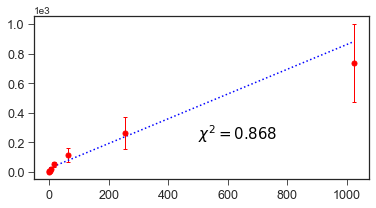

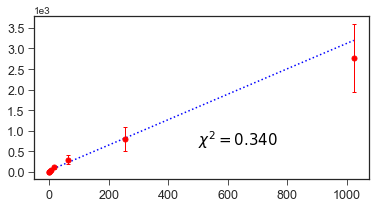

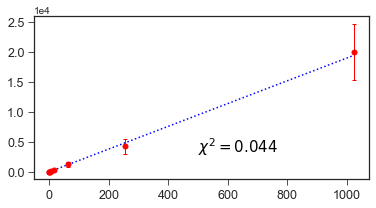

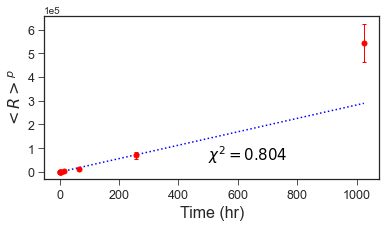

In [6]:
#plot with n= 2, 2.4, 3, 4


for i in [2, 2.4, 3, 4]:

    # Define the opwer function
    # define a : rate_constant, b: exponent c:logistic Intercept
    print ("\nexponent value (1/p) =", i)
    p = 1/i
    def power(x, A, to, Ro):
        return (A*(x-to)+Ro**(1/p))**p

    # fitting power plot with 2sigma
    popt, pcov = curve_fit(power, x, y, bounds=([0,  0, 0], [1, 14400, 10]), sigma=y_err) 
    #print("Popt:", popt)
    #print("pcov: ", pcov)
    print("A =", popt[0], "+/-", pcov[0,0]**0.5)
    print("to =", popt[1], "+/-", pcov[1,1]**0.5)
    print("Ro =", popt[2], "+/-", pcov[2,2]**0.5)

    A = popt[0]
    to = popt[1]
    Ro = popt[2]

    # Calcualte the R_squared value
    best_fit = (A*(x-to)+Ro**(1/p))**p
    R_squared = round(r2_score(y, best_fit), 3)
    ch2, pval = chisquare(y, best_fit)
    print(f"R_2: {R_squared}")
    print('chisquare for normdiscrete: chi2 = %6.3f pvalue = %6.4f' % (ch2, pval))

    # model_fit with fine scale
    xfine = np.linspace(900, 3686400, 100000) 
    f2 = (A*(xfine-to)+Ro**(1/p))**p

    #time scale change from second to hour

    x0b = x0/3600
    xfineb = xfine/3600
    
    #factorial p for radius (fuction)
    rescale_y0 = y0**i
    rescale_y0err = ((((y0+y0_err)/2)**i)**2-(((y0-y0_err)/2)**i)**2)**0.5
    rescale_f2 =f2**i
    
    fig, ax = plt.subplots(figsize=(6,3))
    #log-log
    #ax.loglog(x0b, y0, ['r.'], markersize=10)
    #ax.loglog(x2b, f2, 'b:', label=r'fitting')
    # linear-linear
    ax.errorbar(x0b, rescale_y0, rescale_y0err, fmt='r.', markersize=10, elinewidth=1, capsize=2,label='experiment')
    ax.plot(xfineb, rescale_f2, 'b:', label=r'fitting')
    #ax.text(0, 28**i, r'p={}'.format(i), color="k", fontsize=16)
    # label in a defalut axes coords
    #ax.text(0.3, 0.87, r'p={}'.format(i), ha='center', va='center', transform=ax.transAxes, size=15, color='red')
    ax.text(500, 15**i, r'$\chi^2={:.3f}$'.format(ch2), color="k", fontsize=15)
    #ax.text(500, 12**i, r'p_val={:.4f}'.format(pval), color="k", fontsize=15)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.xticks(fontsize=12.5)
    plt.yticks(fontsize=12.5)    
    #plt.xlim(0, 70)
    #plt.ylim(0, 14000)
    
plt.xlabel("Time (hr)", fontsize=16)
plt.ylabel(r'$<R>^p{} $', fontsize=16)

In [7]:
# plot R_squre versus eponent value 

In [8]:
#plot with n= 1.5-4
# assigne x and y values
x0 = df0['time_s'].to_numpy()
y0 = df0['radius'].to_numpy()
y0_err = df0['radius_err'].to_numpy()
x = df['time_s'].to_numpy()
y = df['radius'].to_numpy()
y_err = df['radius_err'].to_numpy()

rsq_dict ={}
chi_dict ={}
pval_dict ={}

for i in np.linspace(1.5, 4, 200):

    # Define the opwer function
    # define a : rate_constant, b: exponent c:logistic Intercept
    print ("\nexponent value (1/p) =", i)
    p = 1/i
    def power(x, A, to, Ro):
        return (A*(x-to)+Ro**(1/p))**p

    # fitting power plot with 2sigma
    popt, pcov = curve_fit(power, x, y, bounds=([0,  0, 0], [1, 14400, 10]), sigma=y_err) 
    #print("Popt:", popt)
    #print("pcov: ", pcov)
    print("\nA =", popt[0], "+/-", pcov[0,0]**0.5)
    print("to =", popt[1], "+/-", pcov[1,1]**0.5)
    print("Ro =", popt[2], "+/-", pcov[2,2]**0.5)
    AtoR= (popt[2]**i)-popt[0]*popt[1]
    print("AtoR =", AtoR)
    
    A = popt[0]
    to = popt[1]
    Ro = popt[2]
    
    # Calcualte the R_squared value
    best_fit =(A*(x-to)+Ro**(1/p))**p
    R_squared = round(r2_score(y, best_fit), 4)
    ch2, pval = chisquare(y, best_fit)
    print(f"R_2: {R_squared}")
    print('chisquare for normdiscrete: chi2 = %6.3f pvalue = %6.4f' % (ch2, pval))
    
    rsq_dict[i] = R_squared
    chi_dict[i] = ch2
    pval_dict[i] = pval
    
    # model_fit with fine scale
    xfine = np.linspace(900, 3686400, 100000) 
    f2 = (A*(xfine-to)+Ro**(1/p))**p

rsq_df1=pd.DataFrame.from_dict(rsq_dict, orient='index', columns=['Rsquared'])
chi_df1=pd.DataFrame.from_dict(chi_dict, orient='index', columns=['chi_square'])
pval_df1=pd.DataFrame.from_dict(pval_dict, orient='index', columns=['p_val'])



exponent value (1/p) = 1.5

A = 4.091616352867105e-05 +/- 1.2628372158703455e-05
to = 6176.02768927487 +/- 1.385988342678844e-05
Ro = 5.763350516920646 +/- 1.21981371680645
AtoR = 13.583364255909158
R_2: 0.928
chisquare for normdiscrete: chi2 =  1.939 pvalue = 0.7470

exponent value (1/p) = 1.5125628140703518

A = 4.279593743863428e-05 +/- 1.3170780279589214e-05
to = 6219.597133669033 +/- 1.4008667657152531e-05
Ro = 5.752235604026074 +/- 1.2138687891748317
AtoR = 13.836475141668695
R_2: 0.929
chisquare for normdiscrete: chi2 =  1.906 pvalue = 0.7530

exponent value (1/p) = 1.5251256281407035

A = 4.4758811769026145e-05 +/- 1.3734236402443312e-05
to = 6289.896770216825 +/- 1.4157987925015086e-05
Ro = 5.741375374303169 +/- 1.2078338271119196
AtoR = 14.093035191646646
R_2: 0.93
chisquare for normdiscrete: chi2 =  1.873 pvalue = 0.7590

exponent value (1/p) = 1.5376884422110553

A = 4.680832747560643e-05 +/- 1.4319445119144993e-05
to = 6202.141698794308 +/- 1.4315746125243457e-05
Ro = 5.7


exponent value (1/p) = 1.9271356783919598

A = 0.00018120523250449839 +/- 4.787540490371488e-05
to = 6804.222669137802 +/- 1.9971800975231642e-05
Ro = 5.338676451682647 +/- 1.0036640283355434
AtoR = 23.993902148901164
R_2: 0.9595
chisquare for normdiscrete: chi2 =  0.994 pvalue = 0.9107

exponent value (1/p) = 1.9396984924623115

A = 0.00018908657993719325 +/- 4.962541657891732e-05
to = 6778.804952604471 +/- 2.0190734850924636e-05
Ro = 5.324194136855639 +/- 0.9969773419741437
AtoR = 24.346150878322398
R_2: 0.9603
chisquare for normdiscrete: chi2 =  0.971 pvalue = 0.9141

exponent value (1/p) = 1.9522613065326633

A = 0.00019729726982934746 +/- 5.142858443654112e-05
to = 6697.148085431356 +/- 2.042215406761784e-05
Ro = 5.308462105409586 +/- 0.9905539363468812
AtoR = 24.699934638655943
R_2: 0.9611
chisquare for normdiscrete: chi2 =  0.949 pvalue = 0.9174

exponent value (1/p) = 1.964824120603015

A = 0.00020585043556999247 +/- 5.32859368741203e-05
to = 6718.755875333789 +/- 2.0637181962


exponent value (1/p) = 2.3668341708542715

A = 0.0007712167927845052 +/- 0.00014530460458536567
to = 7445.054504733097 +/- 2.7839579958510885e-05
Ro = 4.832186830220364 +/- 0.7358088501119154
AtoR = 35.87371167737998
R_2: 0.984
chisquare for normdiscrete: chi2 =  0.374 pvalue = 0.9846

exponent value (1/p) = 2.379396984924623

A = 0.0008027430724755537 +/- 0.00014935775806771442
to = 7477.758281381022 +/- 92956345440.94952
Ro = 4.817561469745518 +/- 3585080.13288512
AtoR = 36.139474656965696
R_2: 0.9845
chisquare for normdiscrete: chi2 =  0.361 pvalue = 0.9855

exponent value (1/p) = 2.391959798994975

A = 0.0008354940401838576 +/- 0.00015455812952814153
to = 7498.098900596157 +/- 97963692786.26791
Ro = 4.8024496022278305 +/- 3851995.9112547897
AtoR = 36.396444843273045
R_2: 0.9851
chisquare for normdiscrete: chi2 =  0.348 pvalue = 0.9865

exponent value (1/p) = 2.4045226130653266

A = 0.0008695142697092764 +/- 0.00015710781342285744
to = 7503.710213821172 +/- 2.8460243605092324e-05
R

R_2: 0.9971
chisquare for normdiscrete: chi2 =  0.075 pvalue = 0.9993

exponent value (1/p) = 2.819095477386935

A = 0.0031040549060807683 +/- 0.0002842974368898079
to = 8186.22908778917 +/- 26968083241.733704
Ro = 4.29205266659023 +/- 2097932.767718075
AtoR = 35.33905866548201
R_2: 0.9973
chisquare for normdiscrete: chi2 =  0.071 pvalue = 0.9994

exponent value (1/p) = 2.8316582914572868

A = 0.0032217051192663464 +/- 0.00031792015209100463
to = 8213.15738095176 +/- 62259625621.099594
Ro = 4.278061068424063 +/- 4943365.39923785
AtoR = 34.84178414268307
R_2: 0.9974
chisquare for normdiscrete: chi2 =  0.068 pvalue = 0.9994

exponent value (1/p) = 2.8442211055276383

A = 0.0033435539876422015 +/- 0.0002968498963315707
to = 8264.26551980546 +/- 47461621710.68378
Ro = 4.266089732774562 +/- 3843022.6995177944
AtoR = 34.30418596463542
R_2: 0.9975
chisquare for normdiscrete: chi2 =  0.064 pvalue = 0.9995

exponent value (1/p) = 2.85678391959799

A = 0.0034697397509611603 +/- 0.000303453358508


A = 0.012130380033690024 +/- 0.0012302502276866454
to = 8973.581737694698 +/- 38870622227.05393
Ro = 3.7655648927620664 +/- 6808655.0422409
AtoR = -29.74613858719745
R_2: 0.9919
chisquare for normdiscrete: chi2 =  0.118 pvalue = 0.9983

exponent value (1/p) = 3.309045226130653

A = 0.012557630502470498 +/- 0.0014355629015292213
to = 8995.370297589343 +/- 140986010863.80853
Ro = 3.7520829049789666 +/- 25255734.95433608
AtoR = -33.47402635896326
R_2: 0.9914
chisquare for normdiscrete: chi2 =  0.124 pvalue = 0.9982

exponent value (1/p) = 3.321608040201005

A = 0.012999208424940997 +/- 0.0014575535831365329
to = 9001.316272539661 +/- 75002324409.76338
Ro = 3.735675385719983 +/- 13766592.320015393
AtoR = -37.35996305565861
R_2: 0.991
chisquare for normdiscrete: chi2 =  0.130 pvalue = 0.9980

exponent value (1/p) = 3.334170854271357

A = 0.01345557664617954 +/- 0.001453879104203613
to = 9046.265380070035 +/- 48534106605.59713
Ro = 3.7264187758959983 +/- 9088017.686721703
AtoR = -41.4100590


A = 0.04983218570740059 +/- 0.01362584237313435
to = 9893.060531975474 +/- 59580066646.252464
Ro = 3.119362124915491 +/- 31244813.43090837
AtoR = -415.4811434498157
R_2: 0.9616
chisquare for normdiscrete: chi2 =  0.575 pvalue = 0.9658

exponent value (1/p) = 3.8366834170854274

A = 0.051492748640181815 +/- 0.018335354279227268
to = 9927.05177932017 +/- 109472375567.87622
Ro = 3.1060257620737586 +/- 59001726.98002118
AtoR = -433.82569707108644
R_2: 0.9606
chisquare for normdiscrete: chi2 =  0.590 pvalue = 0.9642

exponent value (1/p) = 3.849246231155779

A = 0.05320687233088701 +/- 0.0484525714530907
to = 9962.111572288088 +/- 346766829827.4132
Ro = 3.093301799440026 +/- 191997554.19519675
AtoR = -452.82810962615287
R_2: 0.9596
chisquare for normdiscrete: chi2 =  0.605 pvalue = 0.9625

exponent value (1/p) = 3.861809045226131

A = 0.05497624618778086 +/- 0.01757706758966656
to = 9976.734408224132 +/- 103798858088.08192
Ro = 3.068900137880039 +/- 59693243.78564315
AtoR = -472.5147559515

In [9]:
rsq_df1

,Rsquared
1.500000,0.9280
1.512563,0.9290
1.525126,0.9300
1.537688,0.9310
1.550251,0.9320
...,...
3.949749,0.9515
3.962312,0.9504
3.974874,0.9494
3.987437,0.9483


rsq_max: 0.998
rsq_idmax: 2.907035175879397
1/rsq_idmax: 0.3439930855661193

chi_square_min: 0.0443393997300488
chi_square_idmin: 2.9949748743718594
1/chi_square_idmin: 0.3338926174496644

pval_max: 0.9997578542889066
pval_idmax: 2.9949748743718594
1/pval_idmax: 0.3338926174496644


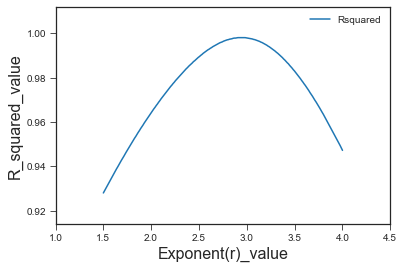

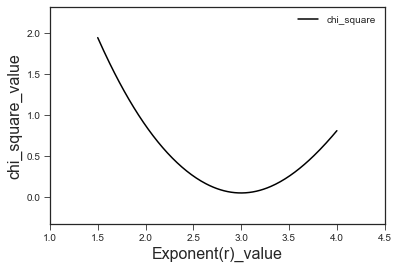

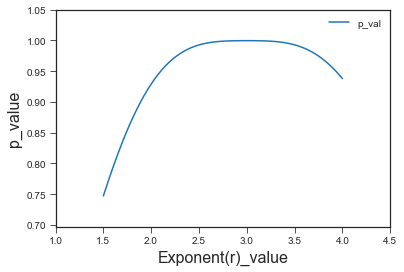

In [10]:
print("rsq_max:", rsq_df1["Rsquared"].max())
print("rsq_idmax:", rsq_df1["Rsquared"].idxmax())
print("1/rsq_idmax:", 1/rsq_df1["Rsquared"].idxmax())

print("\nchi_square_min:", chi_df1["chi_square"].min())
print("chi_square_idmin:", chi_df1["chi_square"].idxmin())
print("1/chi_square_idmin:", 1/chi_df1["chi_square"].idxmin())

print("\npval_max:", pval_df1["p_val"].max())
print("pval_idmax:", pval_df1["p_val"].idxmax())
print("1/pval_idmax:", 1/pval_df1["p_val"].idxmax())

rsq_df1.plot(y='Rsquared', kind = 'line')
plt.xlabel("Exponent(r)_value", fontsize=16)
plt.ylabel( "R_squared_value", fontsize=16)
plt.margins(0.2)
plt.show()

chi_df1.plot(y='chi_square', kind = 'line',color='k')
plt.xlabel("Exponent(r)_value", fontsize=16)
plt.ylabel( "chi_square_value", fontsize=16)
plt.margins(0.2)
plt.show()

pval_df1.plot(y='p_val', kind = 'line')
plt.xlabel("Exponent(r)_value", fontsize=16)
plt.ylabel( "p_value", fontsize=16)
plt.margins(0.2)
plt.show()

In [11]:
#plot with n= 1.5-4
# assigne x and y values
x0 = df0['time_s'].to_numpy()
y0 = df0['radius'].to_numpy()
y0_err = df0['radius_err'].to_numpy()
x = df['time_s'].to_numpy()
y = df['radius'].to_numpy()
y_err = df['radius_err'].to_numpy()

rsq2_dict ={}
chi2_dict ={}
pval2_dict ={}

for i in np.linspace(1.5, 4, 200):

    # Define the opwer function
    # define a : rate_constant, b: exponent c:logistic Intercept
    print ("\nexponent value (1/p) =", i)
    p = 1/i
    
    def power(x, A):
        return (A*(x))**p

    # fitting power plot with 2sigma
    popt, pcov = curve_fit(power, x, y, bounds=([0], [1]), sigma=y_err) 
    #print("Popt:", popt)
    #print("pcov: ", pcov)
    #print("\nA =", popt[0], "+/-", pcov[0,0]**0.5)
    #print("to =", popt[1], "+/-", pcov[1,1]**0.5)

    A = popt[0]
        
    # Calcualte the R_squared value
    best_fit =(A*(x))**p

    # Calcualte the chi and R_squared values
    R_squared = round(r2_score(y, best_fit), 4)
    ch2, pval = chisquare(y, best_fit)
    print(f"R_2: {R_squared}")
    print('chisquare for normdiscrete: chi2 = %6.3f pvalue = %6.4f' % (ch2, pval))
    
    rsq2_dict[i] = R_squared
    chi2_dict[i] = ch2
    pval2_dict[i] = pval
    
    # model_fit with fine scale
    xfine = np.linspace(900, 3686400, 100000) 
    f2 = (A*(xfine))**p

rsq_df2=pd.DataFrame.from_dict(rsq2_dict, orient='index', columns=['Rsquared2'])
chi_df2=pd.DataFrame.from_dict(chi2_dict, orient='index', columns=['chi_square2'])
pval_df2=pd.DataFrame.from_dict(pval2_dict, orient='index', columns=['p_val2'])


exponent value (1/p) = 1.5
R_2: 0.5455
chisquare for normdiscrete: chi2 = 32.371 pvalue = 0.0000

exponent value (1/p) = 1.5125628140703518
R_2: 0.5517
chisquare for normdiscrete: chi2 = 30.988 pvalue = 0.0000

exponent value (1/p) = 1.5251256281407035
R_2: 0.5579
chisquare for normdiscrete: chi2 = 29.673 pvalue = 0.0000

exponent value (1/p) = 1.5376884422110553
R_2: 0.564
chisquare for normdiscrete: chi2 = 28.423 pvalue = 0.0000

exponent value (1/p) = 1.550251256281407
R_2: 0.5701
chisquare for normdiscrete: chi2 = 27.232 pvalue = 0.0000

exponent value (1/p) = 1.5628140703517588
R_2: 0.5762
chisquare for normdiscrete: chi2 = 26.099 pvalue = 0.0000

exponent value (1/p) = 1.5753768844221105
R_2: 0.5823
chisquare for normdiscrete: chi2 = 25.019 pvalue = 0.0000

exponent value (1/p) = 1.5879396984924623
R_2: 0.5883
chisquare for normdiscrete: chi2 = 23.990 pvalue = 0.0001

exponent value (1/p) = 1.600502512562814
R_2: 0.5944
chisquare for normdiscrete: chi2 = 23.009 pvalue = 0.0001



R_2: 0.953
chisquare for normdiscrete: chi2 =  1.002 pvalue = 0.9094

exponent value (1/p) = 2.5804020100502516
R_2: 0.9553
chisquare for normdiscrete: chi2 =  0.952 pvalue = 0.9170

exponent value (1/p) = 2.592964824120603
R_2: 0.9576
chisquare for normdiscrete: chi2 =  0.903 pvalue = 0.9241

exponent value (1/p) = 2.6055276381909547
R_2: 0.9598
chisquare for normdiscrete: chi2 =  0.856 pvalue = 0.9308

exponent value (1/p) = 2.6180904522613067
R_2: 0.9619
chisquare for normdiscrete: chi2 =  0.810 pvalue = 0.9370

exponent value (1/p) = 2.6306532663316586
R_2: 0.964
chisquare for normdiscrete: chi2 =  0.767 pvalue = 0.9428

exponent value (1/p) = 2.64321608040201
R_2: 0.9659
chisquare for normdiscrete: chi2 =  0.725 pvalue = 0.9482

exponent value (1/p) = 2.6557788944723617
R_2: 0.9679
chisquare for normdiscrete: chi2 =  0.684 pvalue = 0.9532

exponent value (1/p) = 2.6683417085427137
R_2: 0.9697
chisquare for normdiscrete: chi2 =  0.646 pvalue = 0.9579

exponent value (1/p) = 2.68090

R_2: 0.9411
chisquare for normdiscrete: chi2 =  0.929 pvalue = 0.9203

exponent value (1/p) = 3.7864321608040203
R_2: 0.9394
chisquare for normdiscrete: chi2 =  0.959 pvalue = 0.9160

exponent value (1/p) = 3.798994974874372
R_2: 0.9377
chisquare for normdiscrete: chi2 =  0.988 pvalue = 0.9116

exponent value (1/p) = 3.811557788944724
R_2: 0.9359
chisquare for normdiscrete: chi2 =  1.018 pvalue = 0.9070

exponent value (1/p) = 3.8241206030150754
R_2: 0.9342
chisquare for normdiscrete: chi2 =  1.049 pvalue = 0.9023

exponent value (1/p) = 3.8366834170854274
R_2: 0.9324
chisquare for normdiscrete: chi2 =  1.079 pvalue = 0.8975

exponent value (1/p) = 3.849246231155779
R_2: 0.9307
chisquare for normdiscrete: chi2 =  1.110 pvalue = 0.8926

exponent value (1/p) = 3.861809045226131
R_2: 0.9289
chisquare for normdiscrete: chi2 =  1.142 pvalue = 0.8876

exponent value (1/p) = 3.8743718592964824
R_2: 0.9271
chisquare for normdiscrete: chi2 =  1.173 pvalue = 0.8825

exponent value (1/p) = 3.8869

rsq_max2: 0.997
rsq_idmax2: 3.0452261306532664
1/rsq_idmax2: 0.32838283828382836

chi_square_min2: 0.05848409134598006
chi_square_idmin2: 3.108040201005025
1/chi_square_idmin2: 0.3217461600646726

pval_max2: 0.9995806956227181
pval_idmax2: 3.108040201005025
1/pval_idmax2: 0.3217461600646726


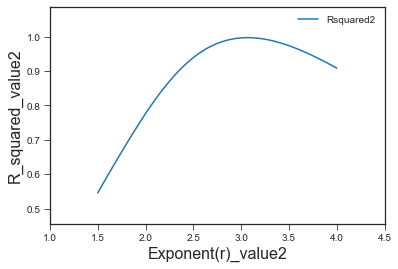

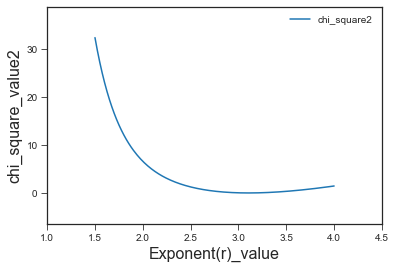

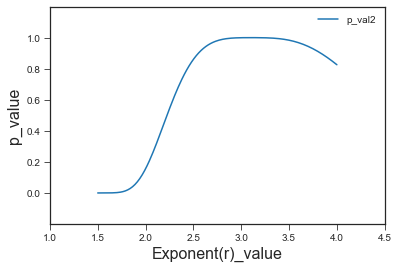

In [12]:
print("rsq_max2:", rsq_df2["Rsquared2"].max())
print("rsq_idmax2:", rsq_df2["Rsquared2"].idxmax())
print("1/rsq_idmax2:", 1/rsq_df2["Rsquared2"].idxmax())

print("\nchi_square_min2:", chi_df2["chi_square2"].min())
print("chi_square_idmin2:", chi_df2["chi_square2"].idxmin())
print("1/chi_square_idmin2:", 1/chi_df2["chi_square2"].idxmin())

print("\npval_max2:", pval_df2["p_val2"].max())
print("pval_idmax2:", pval_df2["p_val2"].idxmax())
print("1/pval_idmax2:", 1/pval_df2["p_val2"].idxmax())

rsq_df2.plot(y='Rsquared2', kind = 'line')
plt.xlabel("Exponent(r)_value2", fontsize=16)
plt.ylabel( "R_squared_value2", fontsize=16)
plt.margins(0.2)
plt.show()

chi_df2.plot(y='chi_square2', kind = 'line')
plt.xlabel("Exponent(r)_value", fontsize=16)
plt.ylabel( "chi_square_value2", fontsize=16)
plt.margins(0.2)
plt.show()

pval_df2.plot(y='p_val2', kind = 'line')
plt.xlabel("Exponent(r)_value", fontsize=16)
plt.ylabel( "p_value", fontsize=16)
plt.margins(0.2)
plt.show()


chi_square_min: 0.0443393997300488
chi_square_idmin: 2.9949748743718594
1/chi_square_idmin: 0.3338926174496644

chi_square_min2: 0.05848409134598006
chi_square_idmin2: 3.108040201005025
1/chi_square_idmin2: 0.3217461600646726


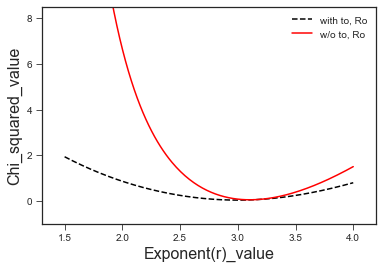

In [13]:
print("\nchi_square_min:", chi_df1["chi_square"].min())
print("chi_square_idmin:", chi_df1["chi_square"].idxmin())
print("1/chi_square_idmin:", 1/chi_df1["chi_square"].idxmin())

print("\nchi_square_min2:", chi_df2["chi_square2"].min())
print("chi_square_idmin2:", chi_df2["chi_square2"].idxmin())
print("1/chi_square_idmin2:", 1/chi_df2["chi_square2"].idxmin())

fig, ax1 = plt.subplots(figsize=(6, 4))
# create shared y axes
chi_df1.plot(y='chi_square', color='k', linestyle= 'dashed', ax =ax1, label = "with to, Ro")
chi_df2.plot(y='chi_square2', color='r', kind= 'line', ax =ax1, label = "w/o to, Ro")
plt.xlabel("Exponent(r)_value", fontsize=16)
plt.ylabel( "Chi_squared_value", fontsize=16)
plt.xlim(1.3, 4.2)
plt.ylim(-1, 8.5)
plt.margins(0.2)
plt.show()

In [14]:
from uncertainties import ufloat
#x = ufloat(1, 0.1)
#exponent_value (1/p) = 3
#A = 0.0039942664008586586 +/- 0.0009278375749382144
#to = 8098.753019922115 +/- 107210907237.25482
#Ro = 4.375821773386308 +/- 7454790.323018013
#R_2: 0.996

A = ufloat(0.003994,  0.00092)
to = ufloat(8098.75301,107210907237.254)
Ro = ufloat(4.375,7454790.32)
R_2= 0.996
    
(A*to)**(1/3)

3.1862173998516234+/-14059664.809772857

In [15]:
-(A*to)+(Ro)**(3)

51.39381485306+/-605473200.3839875

## linear fitting with y_value to the power n
### with to and Ro


exponent value (1/p) = 2

A = 0.0002594264604103227 +/- 9.59763315349294e-05
Ro = 0.010143681598922493 +/- 69518532.09491026
to = 14385.391010732039 +/- 5436372921.174294
R_2: 0.85

exponent value (1/p) = 2.4

A = 0.0007455498742480587 +/- 3.8019138361687325e-05
Ro = 5.547396326672072 +/- 0.9953130871261102
to = 4176.83755527941 +/- 2.8086673499308856e-05
R_2: 0.998

exponent value (1/p) = 2.6

A = 0.001441270095634251 +/- 4.111632588727562e-05
Ro = 5.516651765410242 +/- 0.7086926736196956
to = 13566.48576660712 +/- 2.555930639796508e-05
R_2: 1.0

exponent value (1/p) = 3

A = 0.005370297793952908 +/- 0.00017646340512473822
Ro = 4.118403188682677 +/- 2.3891384292154028
to = 13205.887798403142 +/- 0.0002521509936070643
R_2: 0.998

exponent value (1/p) = 4

A = 0.1408466282547421 +/- 0.017402920567677282
Ro = 0.008587002476186335 +/- 6963682238.038919
to = 14399.999996125776 +/- 114667.96251302023
R_2: 0.98


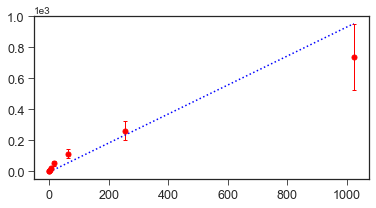

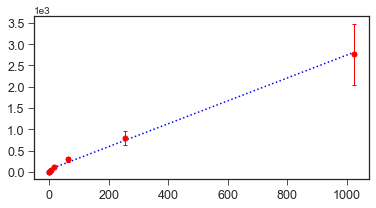

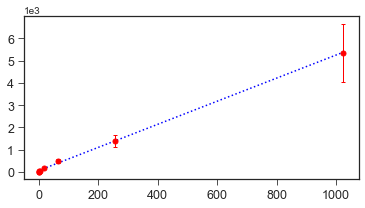

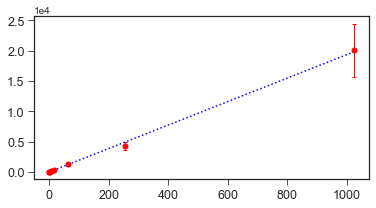

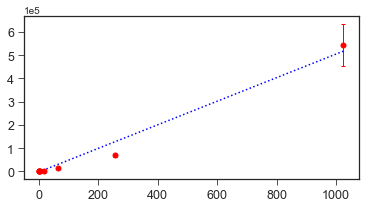

In [16]:
#plot with n= 1.5-4
# assigne x and y values
x0 = df0['time_s'].to_numpy()
y0 = df0['radius'].to_numpy()
y0_err = df0['radius_err'].to_numpy()
x = df['time_s'].to_numpy()
y1 = df['radius'].to_numpy()
y_err = df['radius_err'].to_numpy()

rsq3_dict ={}

for i in [2, 2.4, 2.6, 3, 4]:

    # Define the opwer function; a : rate_constant, b: exponent c:logistic Intercept
    print ("\nexponent value (1/p) =", i)
    p = 1/i
    def power(x, A, Ro, to):
        return A*(x-to)+Ro**(i)
    
    y = y1**i
   
    # fitting power plot with 2sigma
    popt, pcov = curve_fit(power, x, y, bounds=([0,  0, 0.00001], [1,  10, 14400]), sigma=y_err) 
    #print("Popt:", popt)
    #print("pcov: ", pcov)
    print("\nA =", popt[0], "+/-", pcov[0,0]**0.5)
    print("Ro =", popt[1], "+/-", pcov[1,1]**0.5)
    print("to =", popt[2], "+/-", pcov[2,2]**0.5)

    A = popt[0]
    Ro = popt[1]
    to = popt[2]
    
    # Calcualte the R_squared value
    best_fit =A*(x-to)+Ro**(i)
    R_squared = round(r2_score(y, best_fit), 3)
    print(f"R_2: {R_squared}")
    rsq3_dict[i] = R_squared
    # model_fit with fine scale
    xfine = np.linspace(900, 3686400, 100000) 
    f2 = A*(xfine-to)+Ro**(i)

    #time scale change from second to hour

    x0b = x0/3600
    xfineb = xfine/3600
    
    #factorial p for radius (fuction)
    rescale_y0 = y0**i
    rescale_y0err = ((((y0+y0_err))/2)**2+(((y0-y0_err)**i)/2)**2)**0.5
    rescale_f2 =f2
    
    fig, ax = plt.subplots(figsize=(6,3))
    #log-log
    #ax.loglog(x0b, y0, ['r.'], markersize=10)
    #ax.loglog(x2b, f2, 'b:', label=r'fitting')
    # linear-linear
    ax.errorbar(x0b, rescale_y0, rescale_y0err, fmt='r.', markersize=10, elinewidth=1, capsize=2,label='experiment')
    ax.plot(xfineb, rescale_f2, 'b:', label=r'fitting')
    #ax.text(0, 28**i, r'p={}'.format(i), color="k", fontsize=16)
    # label in a defalut axes coords
    #ax.text(0.7, 0.87, r'p={}'.format(i), ha='center', va='center', transform=ax.transAxes, size=15, color='red')
    #ax.text(500, 15**i, r'$\xi^2={}$'.format(R_squared), color="k", fontsize=15)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.xticks(fontsize=12.5)
    plt.yticks(fontsize=12.5)    
    #plt.xlim(0, 70)
    #plt.ylim(-50, 470)
    
#plt.xlabel("Time (hr)", fontsize=16)
#plt.ylabel(r'$<R>^p{} $', fontsize=16)

In [26]:
#plot with n= 1.5-4
# assigne x and y values
x0 = df0['time_s'].to_numpy()
y0 = df0['radius'].to_numpy()
y0_err = df0['radius_err'].to_numpy()
x = df['time_s'].to_numpy()
y1 = df['radius'].to_numpy()
y_err = df['radius_err'].to_numpy()

rsq3_dict ={}

for i in np.linspace(1.5, 4, 500):

    # Define the opwer function; a : rate_constant, b: exponent c:logistic Intercept
    print ("\nexponent value (1/p) =", i)
    p = 1/i
    def power(x, A, Ro, to):
        return A*(x-to)+Ro**(1/p)
    
    y = y1**i
   
    # fitting power plot with 2sigma
    popt, pcov = curve_fit(power, x, y, bounds=([0,  0, 0.00001], [1,  10, 14400]), sigma=y_err) 
    #print("Popt:", popt)
    #print("pcov: ", pcov)
    print("\nA =", popt[0], "+/-", pcov[0,0]**0.5)
    print("Ro =", popt[1], "+/-", pcov[1,1]**0.5)
    print("to =", popt[2], "+/-", pcov[2,2]**0.5)

    A = popt[0]
    Ro = popt[1]
    to = popt[2]
    AtoR= (popt[1]**i)-popt[0]*popt[2]
    print("AtoR =", AtoR)
    
    # Calcualte the R_squared value
    best_fit =A*(x-to)+Ro**(1/p)
    R_squared = r2_score(y, best_fit)
    print(f"R_2: {R_squared}")
    rsq3_dict[i] = R_squared
    # model_fit with fine scale
    xfine = np.linspace(900, 3686400, 100000) 
    f2 = A*(xfine-to)+Ro**(1/p)

rsq_df3=pd.DataFrame.from_dict(rsq3_dict, orient='index',
                       columns=['Rsquared3'])



exponent value (1/p) = 1.5

A = 3.691295023173139e-05 +/- 7.5906850434381524e-06
Ro = 6.12234191456019 +/- 1.4153816259031826
to = 2900.73085301229 +/- 1.4076748986229495e-05
AtoR = 15.041660519966515
R_2: 0.9535870379086814

exponent value (1/p) = 1.5050100200400802

A = 3.754905201048474e-05 +/- 7.681437872042691e-06
Ro = 6.12448004043097 +/- 1.414194145562165
to = 3201.864524682865 +/- 1.4128335390647202e-05
AtoR = 15.174688030881065
R_2: 0.954077795349362

exponent value (1/p) = 1.5100200400801602

A = 3.8195863105537896e-05 +/- 7.773104397944943e-06
Ro = 6.119224879979916 +/- 1.4143274767242422
to = 2765.340483087699 +/- 1.4202114754113342e-05
AtoR = 15.30880118423119
R_2: 0.954565089986751

exponent value (1/p) = 1.5150300601202404

A = 3.885356198571775e-05 +/- 7.865691105595959e-06
Ro = 6.132944594421269 +/- 1.4110041893265284
to = 4216.196017753329 +/- 1.4218859445741207e-05
AtoR = 15.44400674000032
R_2: 0.955048933802385

exponent value (1/p) = 1.5200400801603207

A = 3.9522


A = 0.00011735889083809263 +/- 3.375013735972761e-05
Ro = 0.006321283430980082 +/- 542.6000386490067
to = 14390.89804215304 +/- 1.4868219482283807
AtoR = -1.6887433809929078
R_2: 0.6634445409824066

exponent value (1/p) = 1.7354709418837675

A = 0.0001184254987743011 +/- 3.3789401563939827e-05
Ro = 0.006473578501221223 +/- 545.9375982092213
to = 14390.67830057812 +/- 1.5170824021855036
AtoR = -1.7040642892647553
R_2: 0.6784716955497923

exponent value (1/p) = 1.7404809619238477

A = 0.00011951413039788667 +/- 3.383415640586963e-05
Ro = 0.006631746742659799 +/- 549.1215431291274
to = 14390.448111675962 +/- 1.5468909272657623
AtoR = -1.7197002386859084
R_2: 0.6927957059043681

exponent value (1/p) = 1.745490981963928

A = 0.00012062526424392209 +/- 3.3884477929393384e-05
Ro = 0.00680273333392578 +/- 551.7419473363941
to = 14390.206735522188 +/- 1.573871344494769
AtoR = -1.7356576857111539
R_2: 0.7064470982761171

exponent value (1/p) = 1.750501002004008

A = 0.0001217593901899877 +/- 3.


A = 0.00015748474990615115 +/- 1.928039215779613e-05
Ro = 6.0221320939636485 +/- 1.2973190294180814
to = 6093.139065019161 +/- 1.9892733216063848e-05
AtoR = 31.0728593272971
R_2: 0.9844170125788873

exponent value (1/p) = 1.9358717434869739

A = 0.0001601372094383543 +/- 1.946603129391398e-05
Ro = 6.0149172160383415 +/- 1.2963484432860497
to = 5792.520179184193 +/- 2.0002229067975772e-05
AtoR = 31.319353881285263
R_2: 0.9846558729919291

exponent value (1/p) = 1.940881763527054

A = 0.00016283388510938615 +/- 1.965276168149966e-05
Ro = 6.01670027815609 +/- 1.2931987146775152
to = 6077.317899520594 +/- 2.0050582231210814e-05
AtoR = 31.567263001296332
R_2: 0.9848923497255484

exponent value (1/p) = 1.9458917835671343

A = 0.00016557551045462676 +/- 1.984057417976452e-05
Ro = 6.01858745596887 +/- 1.2899912210370115
to = 6367.806460508418 +/- 2.0097716848431774e-05
AtoR = 31.816584652968174
R_2: 0.9851264557545364

exponent value (1/p) = 1.9509018036072145

A = 0.00016836283164394547 +/- 


A = 0.0003065798159728062 +/- 2.7413788193638852e-05
Ro = 5.815645919944086 +/- 1.215237391679548
to = 2148.3420890554717 +/- 2.3856508931007336e-05
AtoR = 41.9560162619243
R_2: 0.9922304364144039

exponent value (1/p) = 2.1362725450901805

A = 0.0003117142992388761 +/- 2.7629938520924258e-05
Ro = 5.822192100955445 +/- 1.209362981353555
to = 2708.5966313490617 +/- 2.3840213332437092e-05
AtoR = 42.25133323908182
R_2: 0.9923832026503264

exponent value (1/p) = 2.1412825651302603

A = 0.0003169341732550868 +/- 2.7846303535123323e-05
Ro = 5.8170707125936305 +/- 1.2065249682955375
to = 2676.686205759757 +/- 2.393798926505973e-05
AtoR = 42.54750448644622
R_2: 0.9925340513220277

exponent value (1/p) = 2.1462925851703405

A = 0.00032224085430691883 +/- 2.9209283639780518e-05
Ro = 5.814596604557575 +/- 465232.32662100124
to = 2780.2073522842675 +/- 23309943266.366955
AtoR = 42.84450136125344
R_2: 0.9926829933747513

exponent value (1/p) = 2.1513026052104207

A = 0.0003276357818969957 +/- 2.82


A = 0.0005949825613434014 +/- 3.5738708283337555e-05
Ro = 5.850098394473303 +/- 1.0050112630087276
to = 12487.106501555527 +/- 2.4400925609487457e-05
AtoR = 54.05497220397488
R_2: 0.9969509668394627

exponent value (1/p) = 2.3366733466933867

A = 0.0006049093188187206 +/- 3.5921872713434034e-05
Ro = 5.846217832408566 +/- 0.9999794716991802
to = 12537.470304349681 +/- 2.4435543378246348e-05
AtoR = 54.350998065351575
R_2: 0.9970352716082725

exponent value (1/p) = 2.341683366733467

A = 0.0006150009240759094 +/- 3.610282132819391e-05
Ro = 5.840086364492747 +/- 0.9954510733490012
to = 12497.955892448379 +/- 2.4494893854404223e-05
AtoR = 54.64577336024847
R_2: 0.997118071613841

exponent value (1/p) = 2.346693386773547

A = 0.0006252601100769647 +/- 3.6281473789685335e-05
Ro = 5.829889241401209 +/- 0.9918721322723696
to = 12297.275149663557 +/- 2.4600864709817315e-05
AtoR = 54.939210436608974
R_2: 0.9971993763758732

exponent value (1/p) = 2.3517034068136273

A = 0.000635689654647897 +/- 


A = 0.001190992334221805 +/- 4.0728908550109814e-05
Ro = 5.6242266615897 +/- 0.7692913196983399
to = 13885.896122511947 +/- 2.5127533832662765e-05
AtoR = 64.13400098066091
R_2: 0.999301774152516

exponent value (1/p) = 2.5470941883767537

A = 0.0012108113934963377 +/- 4.077114414563135e-05
Ro = 5.616041399667976 +/- 0.7636753416473967
to = 13874.396000669482 +/- 2.5147856740027614e-05
AtoR = 64.27247615061307
R_2: 0.9993306829733748

exponent value (1/p) = 2.552104208416834

A = 0.0012309592814858455 +/- 4.0810718345908043e-05
Ro = 5.60777039476516 +/- 0.7580844808560547
to = 13863.24287913952 +/- 2.5168795369617472e-05
AtoR = 64.40359268765384
R_2: 0.9993584563649223

exponent value (1/p) = 2.5571142284569137

A = 0.0012514414495797066 +/- 4.084787712446575e-05
Ro = 5.599682955527646 +/- 0.7524647623448611
to = 13860.517831719004 +/- 2.518666324155863e-05
AtoR = 64.52712276833958
R_2: 0.9993851022973451

exponent value (1/p) = 2.562124248496994

A = 0.00127226343825763 +/- 4.08828974


A = 0.002121248810386872 +/- 4.456257676901382e-05
Ro = 4.809114758873159 +/- 0.7644196220490177
to = 4025.00979664917 +/- 4.0212577004470686e-05
AtoR = 62.8240486479337
R_2: 0.9996883272536624

exponent value (1/p) = 2.722444889779559

A = 0.0021564987322693478 +/- 0.0001287964871887196
Ro = 4.832201762179619 +/- 1947424.5328248458
to = 4793.773905588963 +/- 37074276341.37646
AtoR = 62.53197278781084
R_2: 0.9996820062518613

exponent value (1/p) = 2.727454909819639

A = 0.00219233327826663 +/- 7.017149437684648e-05
Ro = 4.844710713189029 +/- 1494890.3587802222
to = 5357.728690929345 +/- 28394206547.2971
AtoR = 62.22092940226914
R_2: 0.9996748075516473

exponent value (1/p) = 2.7324649298597192

A = 0.0022287621400466032 +/- 4.591323223239492e-05
Ro = 4.862759851074446 +/- 0.7497528284208078
to = 6023.461492405459 +/- 3.9484519942095567e-05
AtoR = 61.8904392580469
R_2: 0.999666737875792

exponent value (1/p) = 2.7374749498997994

A = 0.0022657951696504783 +/- 7.340059104230284e-05
Ro 

A = 0.00437871055527369 +/- 0.00012258066816115583
Ro = 4.524897068014987 +/- 1.541592362926211
to = 13719.405975767033 +/- 0.00012325205029942385
AtoR = 24.27898955972202
R_2: 0.9986643333911933

exponent value (1/p) = 2.942885771543086

A = 0.0044513963307693276 +/- 0.00012627423005842923
Ro = 4.4992793786702565 +/- 1.5908527202403384
to = 13710.791025850573 +/- 0.00012953008497694403
AtoR = 22.552215465649574
R_2: 0.9986253073902644

exponent value (1/p) = 2.947895791583166

A = 0.004525287402793889 +/- 0.0001300755169224554
Ro = 4.46997753088414 +/- 1.6445076211606906
to = 13664.573435725406 +/- 0.00013659753064973538
AtoR = 20.77383100354821
R_2: 0.9985856680077028

exponent value (1/p) = 2.9529058116232463

A = 0.0046004037526655725 +/- 0.00013398632907476998
Ro = 4.441891553074686 +/- 1.6992433525688604
to = 13641.07769439915 +/- 0.00014393377780352984
AtoR = 18.942733918310815
R_2: 0.9985454204993564

exponent value (1/p) = 2.9579158316633265

A = 0.004676765709275844 +/- 0.000


exponent value (1/p) = 3.1833667334669338

A = 0.009805654982790186 +/- 0.0004754018824725992
Ro = 2.3416750086054094e-05 +/- 0.0
to = 14399.999992712557 +/- 33383.04564506059
AtoR = -141.20143168072053
R_2: 0.9961046925995948

exponent value (1/p) = 3.188376753507014

A = 0.009966774552447138 +/- 0.0006496640635565011
Ro = 0.00704586055749383 +/- 20933219.533546496
to = 14399.989699982354 +/- 138778.77614869794
AtoR = -143.5214507597533
R_2: 0.9960300775819202

exponent value (1/p) = 3.193386773547094

A = 0.010130548871704635 +/- 0.0005001620714210476
Ro = 9.695914779417336e-05 +/- 0.0
to = 14399.999988299274 +/- 33995.3468347137
AtoR = -145.87990363401184
R_2: 0.9959548440422847

exponent value (1/p) = 3.1983967935871744

A = 0.01029702167789546 +/- 0.0005129955635041829
Ro = 3.546146309749143e-06 +/- 0.0
to = 14399.999998314006 +/- 34303.91678689264
AtoR = -148.2771121443339
R_2: 0.9958789989925565

exponent value (1/p) = 3.2034068136272547

A = 0.010466237724316768 +/- 0.00052613


A = 0.017929414392565245 +/- 0.0011782015837362228
Ro = 3.572827539964803e-05 +/- 0.0
to = 14399.999998240497 +/- 45247.56254339491
AtoR = -258.18356722139265
R_2: 0.9929883015184057

exponent value (1/p) = 3.37374749498998

A = 0.018224489472309285 +/- 0.001206195681311769
Ro = 1.0754337066418151e-05 +/- 0.0
to = 14399.999994642934 +/- 45572.6282886353
AtoR = -262.4326483036239
R_2: 0.992895510106558

exponent value (1/p) = 3.3787575150300597

A = 0.01852441784824 +/- 0.001234787036501941
Ro = 6.848136134119526e-05 +/- 0.0
to = 14399.999998939693 +/- 45897.51894066972
AtoR = -266.75161699501444
R_2: 0.9928023198918282

exponent value (1/p) = 3.38376753507014

A = 0.018829309967523956 +/- 0.0012639876475232816
Ro = 4.083142034467471e-05 +/- 0.0
to = 14399.999999901449 +/- 46222.14416467433
AtoR = -271.14206353048934
R_2: 0.9927087902397722

exponent value (1/p) = 3.38877755511022

A = 0.019139216374443477 +/- 0.0012938085082868803
Ro = 3.063106474910683e-05 +/- 0.0
to = 14399.99999937


A = 0.03335351970928755 +/- 0.002776391561296589
Ro = 7.821270499398791e-06 +/- 0.0
to = 14399.999995388162 +/- 57316.640313949
AtoR = -480.2906836599197
R_2: 0.9892428804518986

exponent value (1/p) = 3.564128256513026

A = 0.033903218739622536 +/- 0.002837261400264995
Ro = 0.0002500980160289601 +/- 0.0
to = 14399.999999190093 +/- 57623.565982486674
AtoR = -488.2063498231059
R_2: 0.9891394069600853

exponent value (1/p) = 3.5691382765531063

A = 0.03446199029040571 +/- 0.002899353167885918
Ro = 2.2508441254809674e-05 +/- 0.0
to = 14399.999994985637 +/- 57929.85568021005
AtoR = -496.2526600090373
R_2: 0.9890357294762346

exponent value (1/p) = 3.574148296593186

A = 0.03502999110153694 +/- 0.0030867894202071325
Ro = 0.0051114382039885164 +/- 1235161700.0010126
to = 14399.999999993803 +/- 81777.41537780805
AtoR = -504.43187185545844
R_2: 0.9889318599868718

exponent value (1/p) = 3.5791583166332663

A = 0.03560734838906679 +/- 0.003027293184276766
Ro = 1.2859514848048356e-05 +/- 0.0
to


A = 0.08202516062954468 +/- 0.008716600362609182
Ro = 0.003281603026536989 +/- 0.0
to = 14399.999999419826 +/- 73171.46240214155
AtoR = -1181.162313017556
R_2: 0.9833498711143851

exponent value (1/p) = 3.8396793587174347

A = 0.0833795958083383 +/- 0.008893010747376013
Ro = 0.00024950232333810496 +/- 0.0
to = 14399.999999524345 +/- 73439.67414166412
AtoR = -1200.6661796004116
R_2: 0.9832405664913092

exponent value (1/p) = 3.844689378757515

A = 0.08475626910923922 +/- 0.009072788739346334
Ro = 0.003015704229985955 +/- 0.0
to = 14399.999912354102 +/- 73707.33089229139
AtoR = -1220.4902677443017
R_2: 0.9831311264879493

exponent value (1/p) = 3.849699398797595

A = 0.0861557143646758 +/- 0.0092559947767921
Ro = 0.00043720166817198813 +/- 0.0
to = 14399.999999629705 +/- 73974.27490322794
AtoR = -1240.6422868194281
R_2: 0.9830216573159676

exponent value (1/p) = 3.8547094188376754

A = 0.08757830851228599 +/- 0.009838225926515955
Ro = 0.00202546958338759 +/- 3936711430.3027806
to = 1439

### without to and Ro

In [27]:
#plot with n= 1.5-4
# assigne x and y values
x0 = df0['time_s'].to_numpy()
y0 = df0['radius'].to_numpy()
y0_err = df0['radius_err'].to_numpy()
x = df['time_s'].to_numpy()
y1 = df['radius'].to_numpy()
y_err = df['radius_err'].to_numpy()

rsq4_dict ={}

for i in np.linspace(1.5, 4, 200):

    # Define the opwer function; a : rate_constant, b: exponent c:logistic Intercept
    print ("\nexponent value (1/p) =", i)
    p = 1/i
    def power(x, A):
        return A*(x)
    
    y = y1**i
   
    # fitting power plot with 2sigma
    popt, pcov = curve_fit(power, x, y, bounds=([0], [10]), sigma=y_err) 
    #print("Popt:", popt)
    #print("pcov: ", pcov)
    #print("\nA =", popt[0], "+/-", pcov[0,0]**0.5)
    #print("to =", popt[1], "+/-", pcov[1,1]**0.5)
    #print("Ro =", popt[2], "+/-", pcov[2,2]**0.5)

    A = popt[0]

    
    # Calcualte the R_squared value
    best_fit =A*(x)
    R_squared = round(r2_score(y, best_fit), 4)
    print(f"R_2: {R_squared}")
    rsq4_dict[i] = R_squared
    # model_fit with fine scale
    xfine = np.linspace(900, 3686400, 100000) 
    f2 = A*(xfine)

rsq_df4=pd.DataFrame.from_dict(rsq4_dict, orient='index',
                       columns=['Rsquared4'])

print("\n", rsq_df4["Rsquared4"].max())
print(rsq_df4["Rsquared4"].idxmax())
print(1/rsq_df4["Rsquared4"].idxmax())



exponent value (1/p) = 1.5
R_2: 0.8242

exponent value (1/p) = 1.5125628140703518
R_2: 0.8304

exponent value (1/p) = 1.5251256281407035
R_2: 0.8364

exponent value (1/p) = 1.5376884422110553
R_2: 0.8422

exponent value (1/p) = 1.550251256281407
R_2: 0.8478

exponent value (1/p) = 1.5628140703517588
R_2: 0.8532

exponent value (1/p) = 1.5753768844221105
R_2: 0.8584

exponent value (1/p) = 1.5879396984924623
R_2: 0.8635

exponent value (1/p) = 1.600502512562814
R_2: 0.8684

exponent value (1/p) = 1.6130653266331658
R_2: 0.8731

exponent value (1/p) = 1.6256281407035176
R_2: 0.8777

exponent value (1/p) = 1.6381909547738693
R_2: 0.8821

exponent value (1/p) = 1.650753768844221
R_2: 0.8864

exponent value (1/p) = 1.6633165829145728
R_2: 0.8906

exponent value (1/p) = 1.6758793969849246
R_2: 0.8946

exponent value (1/p) = 1.6884422110552764
R_2: 0.8984

exponent value (1/p) = 1.7010050251256281
R_2: 0.9022

exponent value (1/p) = 1.7135678391959799
R_2: 0.9058

exponent value (1/p) = 1.72


exponent value (1/p) = 3.6231155778894473
R_2: 0.9868

exponent value (1/p) = 3.6356783919597992
R_2: 0.9865

exponent value (1/p) = 3.648241206030151
R_2: 0.9863

exponent value (1/p) = 3.6608040201005028
R_2: 0.986

exponent value (1/p) = 3.6733668341708543
R_2: 0.9857

exponent value (1/p) = 3.6859296482412063
R_2: 0.9854

exponent value (1/p) = 3.698492462311558
R_2: 0.9851

exponent value (1/p) = 3.71105527638191
R_2: 0.9849

exponent value (1/p) = 3.7236180904522613
R_2: 0.9846

exponent value (1/p) = 3.7361809045226133
R_2: 0.9843

exponent value (1/p) = 3.748743718592965
R_2: 0.984

exponent value (1/p) = 3.761306532663317
R_2: 0.9837

exponent value (1/p) = 3.7738693467336684
R_2: 0.9834

exponent value (1/p) = 3.7864321608040203
R_2: 0.9832

exponent value (1/p) = 3.798994974874372
R_2: 0.9829

exponent value (1/p) = 3.811557788944724
R_2: 0.9826

exponent value (1/p) = 3.8241206030150754
R_2: 0.9823

exponent value (1/p) = 3.8366834170854274
R_2: 0.982

exponent value (1/p)

Rsquared_value for linear plot

df3_rsquared_max (with): 0.9997074407752979
df3_rsquared_maxid: 2.687374749498998
1/df3_rsquared_maxid: 0.372110365398956

df4_rsquared_max (wo): 0.9994
df4_rsquared_maxid: 2.7311557788944727
1/df4_rsquared_maxid: 0.3661453541858325


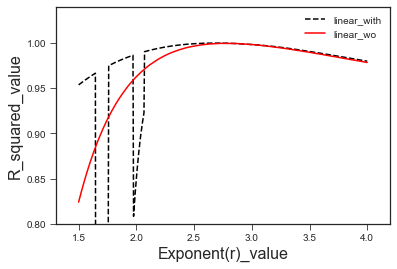

In [28]:
print("Rsquared_value for linear plot\n")
print("df3_rsquared_max (with):", rsq_df3["Rsquared3"].max())
print("df3_rsquared_maxid:",rsq_df3["Rsquared3"].idxmax())
print("1/df3_rsquared_maxid:", 1/rsq_df3["Rsquared3"].idxmax())

print("\ndf4_rsquared_max (wo):", rsq_df4["Rsquared4"].max())
print("df4_rsquared_maxid:",rsq_df4["Rsquared4"].idxmax())
print("1/df4_rsquared_maxid:", 1/rsq_df4["Rsquared4"].idxmax())

fig, ax3 = plt.subplots(figsize=(6, 4))
# create shared y axes
rsq_df3.plot(y='Rsquared3', color='k', linestyle='dashed', ax =ax3, label = "linear_with")
rsq_df4.plot(y='Rsquared4', color='r', kind = 'line', ax =ax3, label = "linear_wo")
plt.xlabel("Exponent(r)_value", fontsize=16)
plt.ylabel( "R_squared_value", fontsize=16)
plt.xlim(1.3, 4.2)
plt.ylim(0.8, 1.04)
plt.margins(0.2)
plt.show()

###### 